# Requirements to run

We recommend generatating a new Anaconda environment before trying to run this project.
The reason is that igraph may have dependencies that conflict with your other project configurations.
As a consequence a new Anaconda environment will likely lead to less debugging and conflicting package issues.

### If you miss a dependency
conda install -c conda-forge python-igraph <br/>
conda install -c conda-forge pycairo <br/>
conda install pandas

Note that the correct igraph package is listed at https://igraph.org/python/doc/tutorial/install.html and NOT at anaconda.org!

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import igraph as ig
import math

In [2]:
#give filename as "id.json"
#1809.json
#546.json
controllables = {
    "Button Bar": "#FFCDD2",
    "Checkbox": "#FF8A65",
    "Date Picker": "#CC6699",
    "Icon": "#CC6699",
    "Input": "#90CAF9",
    "Number Stepper": "#AED581",
    "Radio Button": "#FFB74D",
    "Slider": "#CDDBDC",
    "Text Button": "#CDDC39"
}

tappables = ["BB", "I", "L", "TB"] 
buttons = {"Button Bar": "BB", "Icon": "I", "List Item": "L", "Text Button": "TB"}
checkables = ["Checkbox"] 

In [33]:
def getFile(fileName):
    data = json.load(open("hierarchies/"+fileName))
    dimensions = data['bounds']
    children = data['children']
    return dimensions, children

def getNormalizedBounds(dimensions, bounds):
    x1 = bounds[0] / dimensions[2]
    y1 = bounds[1] / dimensions[3]
    x2 = bounds[2] / dimensions[2]
    y2 = bounds[3] / dimensions[3]
    return [x1, y1, x2, y2]

def sortControlComponents(components):
    sortedComponents = []
    for component in components:
        bounds = component[1]
        componentPosition = 0
        for i in range(len(sortedComponents)):
            compareTo = sortedComponents[i]
            compareToBounds = compareTo[1]
            #If the new component is below the previous one then we move 
            #it to towards the end of component ordering
            if bounds[1] > compareToBounds[3]:
                componentPosition += 1
            #if we have overlap between the components we choose by
            #the component ordering in horizontal plane
            elif bounds[0] > compareToBounds[2]:
                componentPosition += 1
            #otherwise we assume that the current component is before the other component
        sortedComponents.insert(componentPosition, component)
    return sortedComponents
        

def getControlComponents(children):
    controlComponents = []
    def loopForControlComponents(children):
        for c in children:
            clickable = c['clickable']
            itemClass = c['class']
            if(clickable):
                controlComponents.append((clickable, c['bounds'], 
                                          c['componentLabel'], itemClass))
                print("component", clickable, c['bounds'], c['componentLabel'], itemClass )
            elif("children" in c):
                loopForControlComponents(c["children"])
                
    loopForControlComponents(children)
    #print(controlComponents)
    ccCount = len(controlComponents)
    return controlComponents, ccCount

def defineAdjacencyMatrix(controlComponents, ccCount): 
    adjacencyMatrix = [] 
    adjacencyMatrix = adjacencyMatrix + [[0] * (ccCount+2)]
    endVector = [0] * (ccCount+2) 
    notExitControls = 0
    for id in range(ccCount): 
            component = controlComponents[id]
            intermediateVector = []
            if(component[0] == False):
                notExitControls +=1
                intermediateVector = [0] * (ccCount+1) 
                intermediateVector.insert(0, 1) 
            else:
                #if(notExitControls > 0):
                 #   intermediateVector = [1] * notExitControls
                 #   intermediateVector = intermediateVector + 
                 #   [0] * (ccCount-notExitControls+1)
                #else:
                [0] * (ccCount+1)
                intermediateVector.insert(0, 1) 
            adjacencyMatrix = adjacencyMatrix + [intermediateVector] 
            endVector[id+1] = 1
    adjacencyMatrix = adjacencyMatrix + [endVector] 
    print("adjacencymatrix")
    for a in adjacencyMatrix:
        print(a)
    return adjacencyMatrix 

def defineVertices(controlComponents): 
    verticeLabels = ["S"] 
    for c in controlComponents: 
        if(c[2] in buttons): 
            verticeLabels = [buttons[c[2]]] + verticeLabels 
        elif(c[2] in checkables): 
            verticeLabels = ["C"] + verticeLabels 
    verticeLabels = ["E"] + verticeLabels 
    return verticeLabels 

def defineEdges(verticeLabels, ccCount):
    edgeLabels = []
    for v in range(len(verticeLabels)-1,-1,-1):
        #print(v, verticeLabels[v])
        if(verticeLabels[v] in tappables):
            edgeLabels = ["T"] + edgeLabels
        elif(verticeLabels[v] == "E"):
            edgeLabels = (["O"]*ccCount) + edgeLabels
    return edgeLabels

def getMatrix(controlComponents, ccCount):
    adjacencyMatrix = defineAdjacencyMatrix(controlComponents, ccCount) 
    #print("adjMatr", adjacencyMatrix)
    verticeLabels = defineVertices(controlComponents) 
    edgeLabels = defineEdges(verticeLabels, ccCount)
    #print(verticeLabels) 
    #print(edgeLabels)
    
def visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels):
    directed = ig.Graph.Adjacency(adjacencyMatrix, mode="directed") 
    directed.vs["label"] = verticeLabels
    directed.es["label"] = edgeLabels
    layout = directed.layout("rt") 
    return ig.plot(directed, layout=layout, bbox=(0, 0, 350, 350), margin=20) 

def computeHalstead(edgeLabels, verticeLabels):
    #number of unique operators
    n1 = len(set(edgeLabels))
    #number of unique operands. We remove start and end
    n2 = len(set(verticeLabels))-2
    #total frequency of operators
    N1 = len(edgeLabels)
    #total frequency of operands. We remote start and end 
    N2 = len(verticeLabels)-2
    
    firstPart = (n1*N2*(N1+N2))/(2*n2)
    logPart = math.log(n1+n2, 2)
    #rounded to S significant numbers
    return round(firstPart*logPart,3)


def computeMcCabeVG(adjacencyMatrix):
    nodes = len(adjacencyMatrix)
    vertices = 0
    for a in adjacencyMatrix:
        vertices += a.count(1)
    print("vertices", vertices)
    return nodes - vertices

#called from computeWoodEntropy()
def woodComponentComplexity(adjacencyMatrix):
    print("xx")

def computeWoodEntropy(adjacencyMatrix):
    print("type", type(adjacencyMatrix))

def determineControlGraphForFile(file):
    dimensions, children = getFile(file)
    controlComponents, ccCount = getControlComponents(children)
    #we need to sort control components as they are not always
    #in a sensible order from the perspective of how the actions would be performed
    sortedControlComponents = sortControlComponents(controlComponents)
    adjacencyMatrix = defineAdjacencyMatrix(controlComponents, ccCount)
    verticeLabels = defineVertices(controlComponents)
    edgeLabels = defineEdges(verticeLabels, ccCount)

    halstead = computeHalstead(edgeLabels, verticeLabels)
    mcCabe = computeMcCabeVG(adjacencyMatrix)
    wood = computeWoodEntropy(adjacencyMatrix)
    print("Halstead", halstead, "McCabe", mcCabe)
    return adjacencyMatrix, verticeLabels, edgeLabels

## ID 1809 computation

component True [195, 1763, 1245, 1973] Text Button android.support.v7.widget.AppCompatButton
comp (True, [195, 1763, 1245, 1973], 'Text Button', 'android.support.v7.widget.AppCompatButton')
position 0
adjacencymatrix
[0, 0, 0]
[1]
[0, 1, 0]
vertices 2
type <class 'list'>
Halstead 4.755 McCabe 1
['E', 'TB', 'S']
['O', 'T']


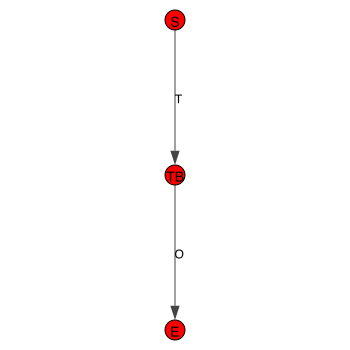

In [23]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1809.json")
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Test

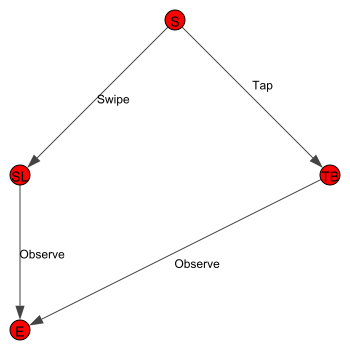

In [18]:
adjacencyMatrix = [[0,0,0,0],[1,0,0,0],[1,0,0,0],[0,1,1,0]]
verticeLabels=['E','SL','TB','S']
edgeLabels=['Observe','Observe','Swipe','Tap']
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Test 2
Corresponds to 492.json

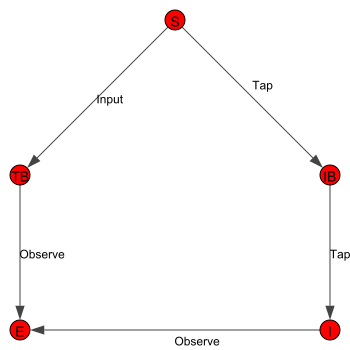

In [20]:
adjacencyMatrix = [[0,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[0,0,1,0,0],[0,1,0,1,0]]
verticeLabels = ['E','TB','I','IB','S']
edgeLabels=['Observe','Observe','Tap','Input','Tap']
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 492 computation

component True [7, 89, 165, 247] Icon android.support.v7.widget.AppCompatImageButton
component True [35, 2251, 1194, 2374] Input com.vanniktech.emoji.EmojiEditText
component True [1212, 2251, 1422, 2374] Text Button android.support.v7.widget.AppCompatButton
component True [193, 287, 1288, 445] Text Button android.widget.LinearLayout
component True [1282, 296, 1422, 436] Icon android.support.v7.widget.AppCompatImageView
component True [35, 287, 193, 445] Icon com.makeramen.roundedimageview.RoundedImageView
position 0
position 1
position 2
position 1
position 2
position 1
Sorteds
[7, 89, 165, 247]
[35, 287, 193, 445]
[193, 287, 1288, 445]
[1282, 296, 1422, 436]
[35, 2251, 1194, 2374]
[1212, 2251, 1422, 2374]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 1, 1, 0]
vertices 12
type <class 'list'>
Halstead 80.0 McCabe -4
['E', 'I', 'I', 'TB', 'TB', 'I', 'S']
['O', 'O', 'O', 'O', 'O', 'O', 'T', 'T', 'T', 'T', 'T']


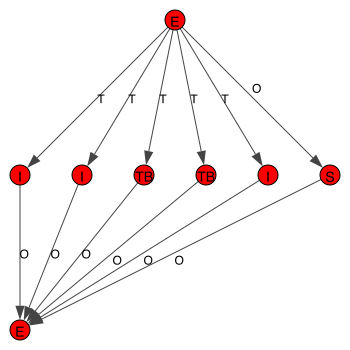

In [32]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("492.json")
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 1863 computation

[(True, [0, 0, 196, 196], 'Icon', 'android.widget.ImageButton'), (True, [247, 2140, 702, 2287], 'Text Button', 'android.support.v7.widget.AppCompatButton'), (True, [737, 2140, 1192, 2287], 'Text Button', 'android.support.v7.widget.AppCompatButton')]
adjacencymatrix
[0, 0, 0, 0, 0]
[1]
[1]
[1]
[0, 1, 1, 1, 0]
vertices 6
Halstead 27.0 McCabe -1


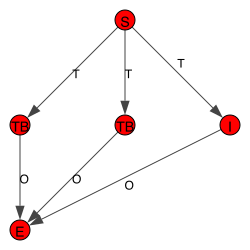

In [5]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1863.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 546 computation

[(True, [0, 84, 196, 280], 'Icon', 'android.widget.ImageButton'), (True, [0, 284, 1440, 538], 'List Item', 'android.widget.LinearLayout'), (True, [0, 542, 1440, 796], 'List Item', 'android.widget.LinearLayout'), (True, [0, 800, 1440, 1054], 'List Item', 'android.widget.LinearLayout')]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 0]
vertices 8
Halstead 48.0 McCabe -2


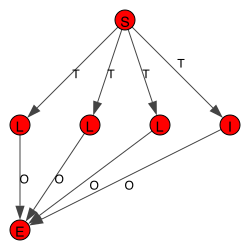

In [6]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("546.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 492 computation (needs fixing)

[(True, [7, 89, 165, 247], 'Icon', 'android.support.v7.widget.AppCompatImageButton'), (True, [35, 2251, 1194, 2374], 'Input', 'com.vanniktech.emoji.EmojiEditText'), (True, [1212, 2251, 1422, 2374], 'Text Button', 'android.support.v7.widget.AppCompatButton'), (True, [193, 287, 1288, 445], 'Text Button', 'android.widget.LinearLayout'), (True, [1282, 296, 1422, 436], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [35, 287, 193, 445], 'Icon', 'com.makeramen.roundedimageview.RoundedImageView')]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 1, 1, 0]
vertices 12
Halstead 80.0 McCabe -4


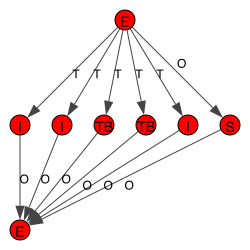

In [7]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("492.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

## Id 758 computation

[(False, [92, 759, 1348, 927], 'Text', 'android.widget.CheckedTextView'), (False, [92, 929, 1348, 1097], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1099, 1348, 1267], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1269, 1348, 1437], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1439, 1348, 1607], 'Text', 'android.widget.CheckedTextView'), (False, [92, 1609, 1348, 1777], 'Text', 'android.widget.CheckedTextView'), (True, [92, 1779, 1348, 1947], 'Text Button', 'android.widget.Button')]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
vertices 19
Halstead 14.265 McCabe -10


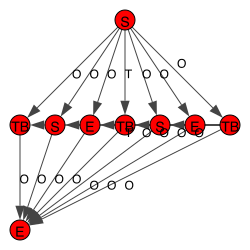

In [8]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("758.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 10596 computation

[(True, [0, 84, 196, 280], 'Icon', 'android.support.v7.widget.AppCompatImageButton'), (True, [1104, 98, 1272, 266], 'Icon', 'android.support.v7.view.menu.ActionMenuItemView'), (True, [1300, 140, 1384, 224], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [0, 308, 1440, 496], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 496, 1440, 684], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 684, 1440, 872], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 872, 1440, 1060], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1060, 1440, 1248], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1248, 1440, 1436], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1436, 1440, 1624], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1624, 1440, 1812], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 1812, 1440, 2000], 'Text Button', 'com.helpshift.views.HSTextView'), (True, [0, 2000, 1440, 

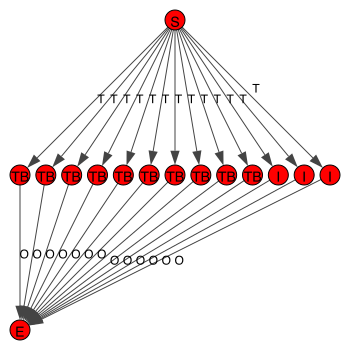

In [11]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("10596.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)

# Id 1074 Computation

[(True, [0, 84, 169, 242], 'Icon', 'android.support.v7.widget.AppCompatImageView'), (True, [282, 817, 1157, 996], 'Input', 'com.careem.acma.ui.PinCodeEditText'), (True, [56, 1052, 1384, 1248], 'Text Button', 'com.careem.acma.widget.CustomFontButton'), (True, [813, 1304, 1210, 1381], 'Text Button', 'com.careem.acma.activity.FontTextView')]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1]
[1]
[1]
[1]
[0, 1, 1, 1, 1, 0]
vertices 8
Halstead 30.0 McCabe -2


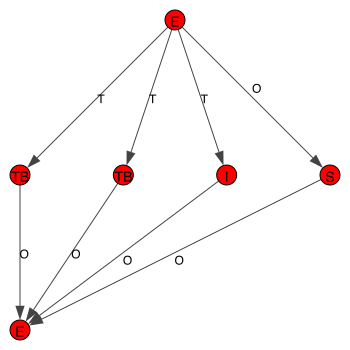

In [12]:
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile("1074.json")
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels)